In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GaussianNoise
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
print("x_train shape: {}, y_train shape: {}".format(x_train.shape, y_train.shape))

x_train shape: (60000, 28, 28), y_train shape: (60000,)


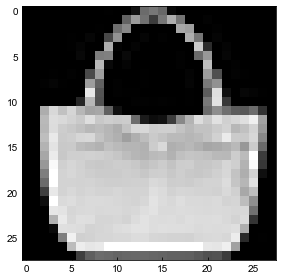

In [4]:
plt.imshow(x_train[100], cmap='gray')

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [6]:
x_train = x_train.reshape(len(x_train), 28*28)
x_val = x_val.reshape(len(x_val), 28*28)
x_test = x_test.reshape(len(x_test), 28*28)

In [7]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)

(54000, 784)
(6000, 784)
(54000,)


In [8]:
x_train = x_train.astype('float32')/255.
x_val = x_val.astype('float32')/255.
x_test = x_test.astype('float32')/255.

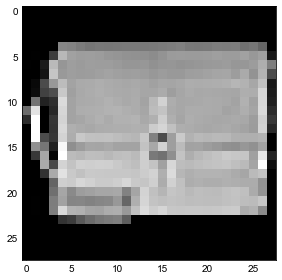

In [9]:
plt.imshow(x_train[10].reshape(28,28), cmap='gray')

In [10]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [20]:
# autoencoder
input_dim = x_train.shape[1]
encoding_dim = y_train.shape[1]
print("Encoding dim: {}".format(encoding_dim))

compression_factor = float(input_dim)/encoding_dim
print("Compression factor: {}".format(compression_factor))

autoencoder = Sequential()
autoencoder.add(Dense(units=4*encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(units=2*encoding_dim, activation='relu'))
autoencoder.add(Dense(units=encoding_dim, activation='relu'))

autoencoder.add(Dense(units=2*encoding_dim, activation='relu'))
autoencoder.add(Dense(units=4*encoding_dim, activation='relu'))
autoencoder.add(Dense(units=input_dim, activation='sigmoid'))

autoencoder.summary()

Encoding dim: 10
Compression factor: 78.4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                31400     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 784)               32144     
Total params: 65,634
Trainable params: 65,634
Non-trainable params: 0
________

In [21]:
# encoder
input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, 
                encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                31400     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 32,430
Trainable params: 32,430
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])

In [23]:
early_stopping = EarlyStopping(min_delta=1e-4)
hist = autoencoder.fit(x_train, x_train, epochs=100, batch_size=128,
                 validation_data=(x_val, x_val), callbacks=[early_stopping])

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 3s 55us/step - loss: 0.3870 - acc: 0.4877 - val_loss: 0.3282 - val_acc: 0.5013
Epoch 2/100
54000/54000 [==============================] - 2s 46us/step - loss: 0.3187 - acc: 0.5027 - val_loss: 0.3140 - val_acc: 0.5022
Epoch 3/100
54000/54000 [==============================] - 2s 46us/step - loss: 0.3113 - acc: 0.5039 - val_loss: 0.3097 - val_acc: 0.5038
Epoch 4/100
54000/54000 [==============================] - 3s 46us/step - loss: 0.3079 - acc: 0.5045 - val_loss: 0.3065 - val_acc: 0.5037
Epoch 5/100
54000/54000 [==============================] - 2s 45us/step - loss: 0.3054 - acc: 0.5049 - val_loss: 0.3043 - val_acc: 0.5043
Epoch 6/100
54000/54000 [==============================] - 2s 45us/step - loss: 0.3033 - acc: 0.5053 - val_loss: 0.3024 - val_acc: 0.5047
Epoch 7/100
54000/54000 [==============================] - 2s 44us/step - loss: 0.3016 - acc: 0.5055 - val_loss: 0.3011 - v

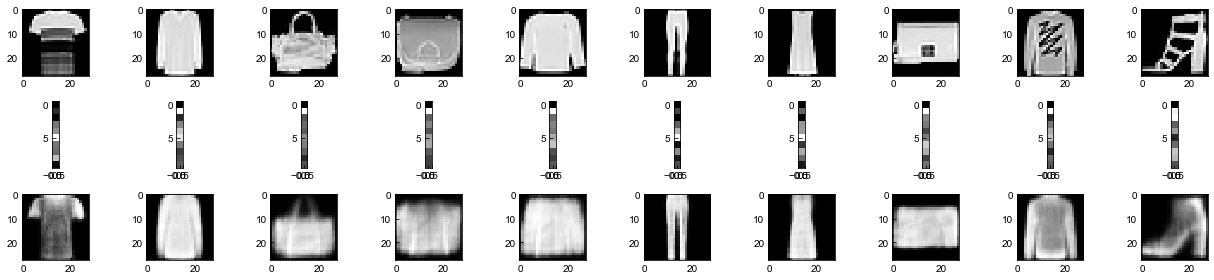

In [16]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i+1)
    plt.imshow(x_test[image_idx].reshape(28,28))
    plt.gray()
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images+i+1)
    plt.imshow(encoded_imgs[image_idx].reshape(10,1))
    plt.gray()
    
    # plot decoded image
    ax = plt.subplot(3, num_images, 2*num_images+i+1)
    plt.imshow(decoded_imgs[image_idx].reshape(28,28))
    plt.gray()

AttributeError: 'Sequential' object has no attribute 'clear_session'

In [ ]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.title('loss')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.title('accuracy')
plt.show()

In [ ]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
pprint(cm)

In [ ]:
y_hat = model.predict(df_test.values, batch_size=64)
y_pred = np.argmax(y_hat,axis=1)

In [ ]:
with open('submission.csv', 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))